# RQ4: Do lightweight explainability techniques (Grad-CAM) enhance interpretability of U-Net-based nuclei segmentation on PanNuke, and does stain normalization improve this further?

**Motivation**
Deep learning is increasingly integrated into clinical workflows where transparency is essential. Lightweight explainability such as Grad-CAM can offer visual cues into model decision-making, yet its effectiveness for biomedical image segmentation, especially under varying preprocessing, is underexplored. This study assesses whether stain normalization improves the clarity and spatial accuracy of Grad-CAM-based explanations and whether these explanations align with biologically relevant regions.

**Hypotheses**
- H0: Stain normalization does not improve Grad-CAM alignment.
- H1: Stain normalization significantly improves Grad-CAM alignment.

We compare U-Net predictions and Grad-CAM maps on original vs Vahadane-normalized inputs and quantify alignment with nuclei masks using point-and-area-based metrics, followed by paired non-parametric tests.


In [1]:
import os
from pathlib import Path
import json
import random
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns

project_root = Path("/workspace/HistoPathologyResearch")

# Paths
DATASET_ROOT = project_root / "dataset"
DATASET_TISSUES = project_root / "dataset_tissues"
ARTIFACTS_RQ3 = project_root / "artifacts" / "rq3_enhanced"
CHECKPOINTS = ARTIFACTS_RQ3 / "checkpoints"

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [4]:
from datasets.pannuke_tissue_dataset import PanNukeTissueDataset
from datasets.paired_list_dataset import gather_all_items_for_tissue
from models.unet_rq3 import create_unet_rq3
from preprocessing.vahadane_gpu import GPUVahadaneNormalizer

# Basic plotting helpers
sns.set_context("notebook")
sns.set_style("whitegrid")

def show_image_mask(img, mask, title=None):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(np.clip((img.permute(1,2,0).cpu().numpy() * 0.229 + 0.485), 0, 1))
    ax[0].set_title("Image")
    ax[0].axis("off")
    ax[1].imshow(mask.cpu().numpy(), cmap="magma")
    ax[1].set_title("Mask")
    ax[1].axis("off")
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()


## Dataset EDA
We summarize the evaluation split and visualize a few random samples per tissue. We also inspect class-0 (background) vs nuclei coverage to understand expected signal for Grad-CAM alignment.


In [5]:
from collections import defaultdict

# Gather available tissues
available_tissues = [p.name for p in DATASET_TISSUES.iterdir() if p.is_dir()]

records = []
for tissue in sorted(available_tissues):
    tissue_root = DATASET_TISSUES / tissue
    for split in ["train", "val", "test"]:
        img_dir = tissue_root / split / "images"
        sem_dir = tissue_root / split / "sem_masks"
        if img_dir.is_dir() and sem_dir.is_dir():
            n_imgs = len([n for n in img_dir.iterdir() if n.suffix == ".png"])            
            records.append({"tissue": tissue, "split": split, "n": n_imgs})

eda_df = pd.DataFrame(records)
eda_pivot = eda_df.pivot(index="tissue", columns="split", values="n").fillna(0).astype(int)
eda_pivot.head()


split,test,train,val
tissue,,,
Adrenal_gland,88,314,35
Bile-duct,84,302,34
Breast,471,1692,188
Colon,288,1036,116
Esophagus,85,305,34


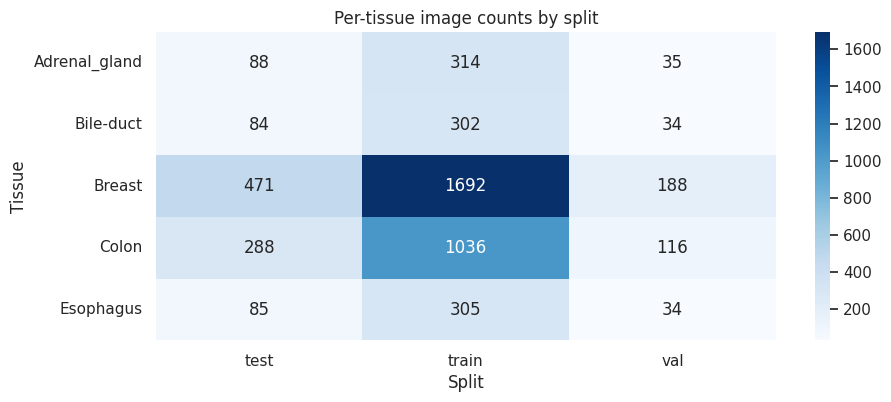

In [6]:
plt.figure(figsize=(10, max(4, len(eda_pivot) * 0.3)))
sns.heatmap(eda_pivot, annot=True, fmt="d", cmap="Blues")
plt.title("Per-tissue image counts by split")
plt.ylabel("Tissue")
plt.xlabel("Split")
plt.show()


In [8]:
from PIL import Image
from scipy.stats import wilcoxon


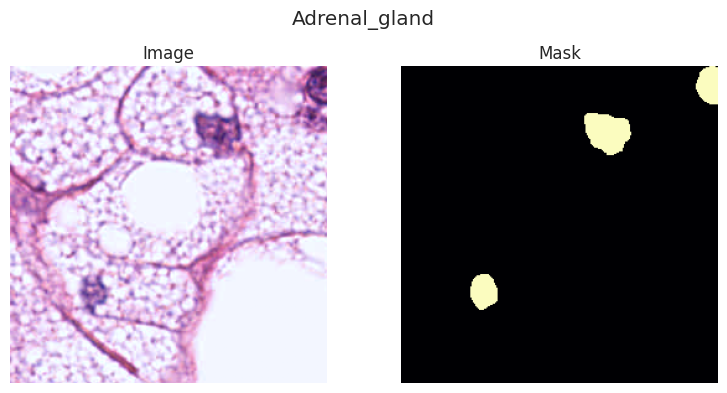

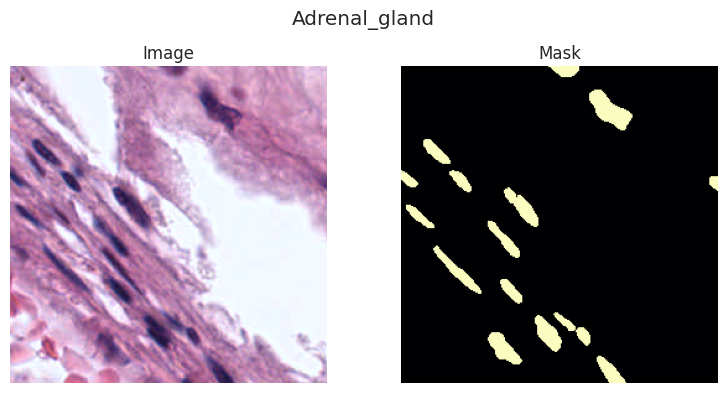

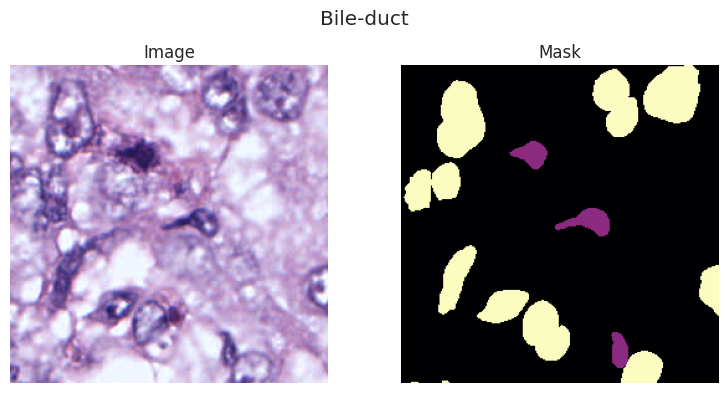

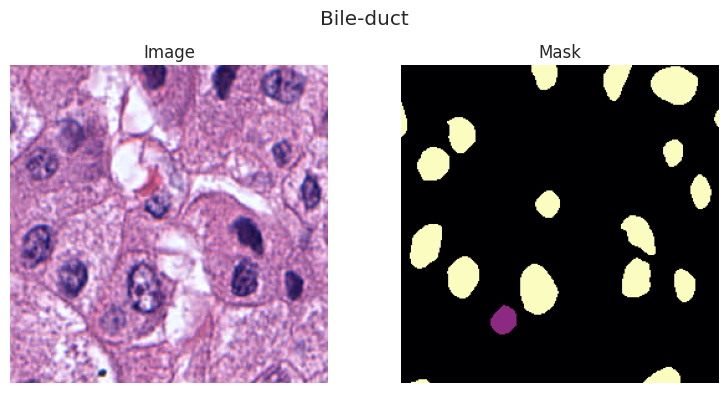

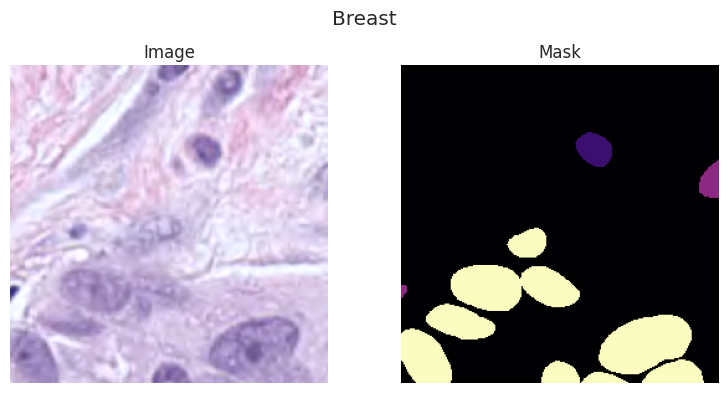

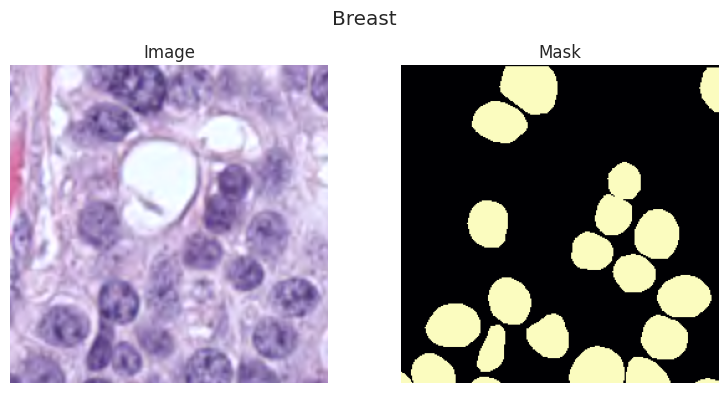

In [9]:
# Sample a few examples per tissue from test split
n_per_tissue = 2
sampled_examples = []
for tissue in sorted(available_tissues):
    items = []
    img_dir = DATASET_TISSUES / tissue / "test" / "images"
    sem_dir = DATASET_TISSUES / tissue / "test" / "sem_masks"
    if img_dir.is_dir() and sem_dir.is_dir():
        names = [n.name for n in img_dir.iterdir() if n.suffix == ".png"]
        for name in random.sample(names, min(n_per_tissue, len(names))):
            items.append({
                "image_path": str(img_dir / name),
                "sem_path": str(sem_dir / name.replace("img_", "sem_", 1))
            })
    sampled_examples.extend([(tissue, e) for e in items])

# Visualize
for tissue, entry in sampled_examples[:6]:
    img = PanNukeTissueDataset.default_image_transform(Image.open(entry["image_path"]).convert("RGB"))
    msk = PanNukeTissueDataset.default_target_transform(Image.open(entry["sem_path"]))
    show_image_mask(img, msk, title=f"{tissue}")


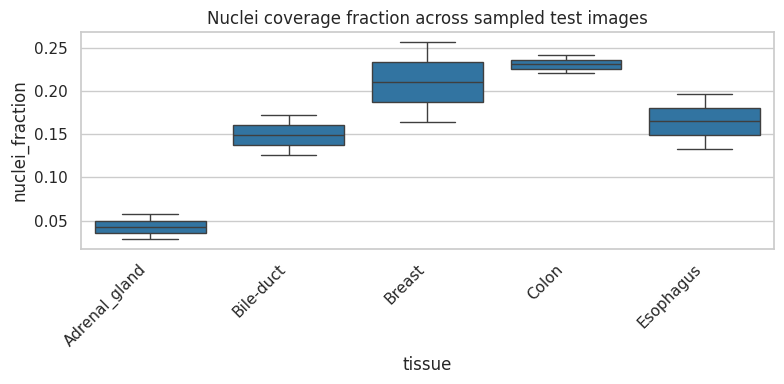

,count,mean,std,min,25%,50%,75%,max
tissue,,,,,,,,
Adrenal_gland,2.0,0.043,0.020,0.029,0.036,0.043,0.050,0.057
Bile-duct,2.0,0.149,0.033,0.126,0.138,0.149,0.161,0.173
Breast,2.0,0.210,0.066,0.164,0.187,0.210,0.233,0.257
Colon,2.0,0.231,0.015,0.220,0.226,0.231,0.236,0.241
Esophagus,2.0,0.165,0.044,0.133,0.149,0.165,0.181,0.196


In [10]:
# Nuclei coverage EDA on a small sample
cov_records = []
for tissue, entry in sampled_examples:
    mask = np.array(Image.open(entry["sem_path"]))
    nuclei_frac = (mask > 0).mean()
    cov_records.append({"tissue": tissue, "nuclei_fraction": nuclei_frac})

cov_df = pd.DataFrame(cov_records)
plt.figure(figsize=(8,4))
sns.boxplot(data=cov_df, x="tissue", y="nuclei_fraction")
plt.xticks(rotation=45, ha="right")
plt.title("Nuclei coverage fraction across sampled test images")
plt.tight_layout()
plt.show()

cov_df.groupby("tissue")["nuclei_fraction"].describe().round(3)


In [13]:
# Model loading: original vs normalized
from models.unet_rq3 import UNetRQ3

def load_model(checkpoint_path: Path, device: torch.device, n_channels=3, n_classes=6):
    model = UNetRQ3(n_channels=n_channels, n_classes=n_classes).to(device)
    if checkpoint_path.exists():
        state = torch.load(checkpoint_path, map_location=device)
        # handle typical structures
        state_dict = state.get('model_state_dict', state)
        model.load_state_dict(state_dict, strict=False)
        print(f"Loaded weights from {checkpoint_path.name}")
    else:
        print(f"Checkpoint not found: {checkpoint_path.name} — using random init")
    model.eval()
    return model

ckpt_orig = CHECKPOINTS / "unet_original_enhanced_best.pth"
ckpt_norm = CHECKPOINTS / "unet_normalized_enhanced_best.pth"

model_original = load_model(ckpt_orig, device)
model_normalized = load_model(ckpt_norm, device)


Loaded weights from unet_original_enhanced_best.pth
Loaded weights from unet_normalized_enhanced_best.pth


In [14]:
# GPU Vahadane normalizer
try:
    normalizer = GPUVahadaneNormalizer(device=device)
    # Fit target using a representative tissue test image if available
    # fallback to a random sampled image from earlier
    if len(sampled_examples) > 0:
        target_path = sampled_examples[0][1]["image_path"]
        normalizer.fit(target_path)
    else:
        print("No sampled examples to fit normalizer; using default stains")
except Exception as e:
    print(f"Normalizer init/fit failed: {e}")
    normalizer = None


🚀 GPUVahadaneNormalizer initialized on cuda
   GPU: NVIDIA RTX A6000
   Memory: 50.9 GB
🎯 Fitting normalizer to target image (shape: torch.Size([256, 256, 3]))
✓ GPU Vahadane normalizer fitted successfully
  Target stain matrix shape: torch.Size([2, 3])
  Hematoxylin vector: [0.33936837 0.8336221  0.43577895]
  Eosin vector: [ 0.89230645 -0.13868405 -0.42959967]


In [15]:
import torch.nn as nn

class SegmentationGradCAM:
    def __init__(self, model: nn.Module, target_layers, device):
        self.model = model
        self.model.eval()
        self.target_layers = target_layers
        self.device = device
        self.activations = []
        self.gradients = []
        self.handles = []
        for layer in self.target_layers:
            self.handles.append(layer.register_forward_hook(self._forward_hook))
            self.handles.append(layer.register_full_backward_hook(self._backward_hook))
    
    def _forward_hook(self, module, input, output):
        self.activations.append(output.detach())
    
    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients.append(grad_output[0].detach())
    
    def _find_target_layers(self):
        # Fallback: use last conv layer in decoder path
        layers = []
        for name, m in self.model.named_modules():
            if isinstance(m, nn.Conv2d) and ('dec' in name or 'up' in name):
                layers.append(m)
        return layers[-1:] if layers else []
    
    def generate(self, x: torch.Tensor) -> np.ndarray:
        self.activations.clear()
        self.gradients.clear()
        if not self.target_layers:
            self.target_layers = self._find_target_layers()
        
        x = x.to(self.device).requires_grad_(True)
        logits = self.model(x)
        # For binary nuclei vs background: take foreground logit (assume channel 1 if 0 is background; fallback to max-prob)
        if logits.shape[1] > 1:
            target = logits[:, 1, :, :].sum()
        else:
            target = logits[:, 0, :, :].sum()
        self.model.zero_grad(set_to_none=True)
        target.backward(retain_graph=False)
        
        # Use last recorded activation/gradient
        A = self.activations[-1]
        G = self.gradients[-1]
        weights = G.mean(dim=(2,3), keepdim=True)  # GAP over spatial dims
        cam = (weights * A).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-6)
        cam_np = cam.squeeze().detach().cpu().numpy()
        return cam_np
    
    def close(self):
        for h in self.handles:
            h.remove()
        self.handles.clear()
        self.activations.clear()
        self.gradients.clear()

# Build wrappers for both models
def build_gradcam_wrappers(model_original, model_normalized, device):
    def pick_layers(model):
        layers = []
        for name, m in model.named_modules():
            if isinstance(m, nn.Conv2d) and ('dec' in name or 'up' in name or 'classifier' not in name):
                layers.append(m)
        return layers[-1:] if layers else []
    
    layers_orig = pick_layers(model_original)
    layers_norm = pick_layers(model_normalized)
    return (
        SegmentationGradCAM(model_original, layers_orig, device),
        SegmentationGradCAM(model_normalized, layers_norm, device)
    )

gradcam_orig, gradcam_norm = build_gradcam_wrappers(model_original, model_normalized, device)


In [16]:
# Explainability metrics
from skimage.measure import regionprops

def cam_energy_in_mask(cam: np.ndarray, mask: np.ndarray) -> float:
    cam = (cam - cam.min()) / (cam.max() + 1e-6)
    if mask.max() > 1:
        mask = (mask > 0).astype(np.uint8)
    return float((cam * mask).sum() / (cam.sum() + 1e-6))


def pointing_game(cam: np.ndarray, mask: np.ndarray) -> float:
    # Hit if argmax of cam falls inside nuclei mask
    y, x = np.unravel_index(np.argmax(cam), cam.shape)
    return float(mask[y, x] > 0)


def cam_iou_threshold(cam: np.ndarray, mask: np.ndarray, thr: float = 0.5) -> float:
    cam_bin = (cam >= thr).astype(np.uint8)
    mask_bin = (mask > 0).astype(np.uint8)
    inter = np.logical_and(cam_bin, mask_bin).sum()
    union = np.logical_or(cam_bin, mask_bin).sum()
    return float(inter / (union + 1e-6))


In [17]:
# Evaluation loop on a moderate sample size per tissue
results = []
examples_per_tissue = 20

for tissue in sorted(available_tissues):
    img_dir = DATASET_TISSUES / tissue / "test" / "images"
    sem_dir = DATASET_TISSUES / tissue / "test" / "sem_masks"
    if not (img_dir.is_dir() and sem_dir.is_dir()):
        continue
    names = [n.name for n in img_dir.iterdir() if n.suffix == ".png"]
    names = random.sample(names, min(examples_per_tissue, len(names)))
    for name in names:
        img_path = img_dir / name
        sem_path = sem_dir / name.replace("img_", "sem_", 1)
        # Load
        img = PanNukeTissueDataset.default_image_transform(Image.open(img_path).convert("RGB"))
        mask = PanNukeTissueDataset.default_target_transform(Image.open(sem_path))
        img_batch = img.unsqueeze(0)
        # GradCAM original
        cam_orig = gradcam_orig.generate(img_batch)
        # GradCAM normalized inputs (optional: normalize image first)
        if normalizer is not None:
            rgb_np = np.array(Image.open(img_path).convert("RGB"))
            norm_rgb = normalizer.transform(rgb_np)
            norm_tensor = PanNukeTissueDataset.default_image_transform(Image.fromarray(norm_rgb))
            cam_norm = gradcam_norm.generate(norm_tensor.unsqueeze(0))
        else:
            cam_norm = gradcam_norm.generate(img_batch)
        m = mask.numpy()
        results.append({
            "tissue": tissue,
            "image_id": name,
            "energy_orig": cam_energy_in_mask(cam_orig, m),
            "energy_norm": cam_energy_in_mask(cam_norm, m),
            "point_orig": pointing_game(cam_orig, m),
            "point_norm": pointing_game(cam_norm, m),
            "iou_orig": cam_iou_threshold(cam_orig, m, thr=0.5),
            "iou_norm": cam_iou_threshold(cam_norm, m, thr=0.5),
        })

res_df = pd.DataFrame(results)
res_df.head()


🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing batch of 1 images on GPU...
🔄 Processing bat

,tissue,image_id,energy_orig,energy_norm,point_orig,point_norm,iou_orig,iou_norm
0,Adrenal_gland,img_Adrenal_gland_3_01100.png,0.545857,0.171612,1.0,0.0,0.000484,0.000000
1,Adrenal_gland,img_Adrenal_gland_1_01171.png,0.748802,0.727054,1.0,1.0,0.010128,0.018871
2,Adrenal_gland,img_Adrenal_gland_3_01463.png,0.584300,0.173858,0.0,0.0,0.009645,0.020531
3,Adrenal_gland,img_Adrenal_gland_1_01196.png,0.425850,0.572378,0.0,0.0,0.000617,0.016972
4,Adrenal_gland,img_Adrenal_gland_1_01531.png,0.614148,0.225854,1.0,0.0,0.062535,0.002354


In [18]:
# Paired statistics: Wilcoxon signed-rank tests per metric (H1: normalized > original)
stats_rows = []
for metric in ["energy", "point", "iou"]:
    x = res_df[f"{metric}_orig"].values
    y = res_df[f"{metric}_norm"].values
    # Wilcoxon signed-rank for paired samples
    stat, p = wilcoxon(y, x, zero_method='wilcox', alternative='greater', method='approx')
    diff = y - x
    # Effect size: r = Z / sqrt(N); approximate Z from statistic via normal approximation
    # scipy returns statistic; we use standardized z from p (one-sided)
    from scipy.stats import norm
    z = norm.isf(p) if p > 0 else np.inf
    r = z / np.sqrt(len(diff))
    stats_rows.append({"metric": metric, "n": len(diff), "wilcoxon_stat": stat, "p_value": p, "effect_r": r, "mean_diff": float(diff.mean())})

stats_df = pd.DataFrame(stats_rows)
stats_df


,metric,n,wilcoxon_stat,p_value,effect_r,mean_diff
0,energy,100,726.0,1.00000,-0.593889,-0.182239
1,point,100,172.0,0.99997,-0.401189,-0.260000
2,iou,100,1906.0,0.85790,-0.107093,-0.018585


🔄 Processing batch of 1 images on GPU...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.094994396..1.08956].


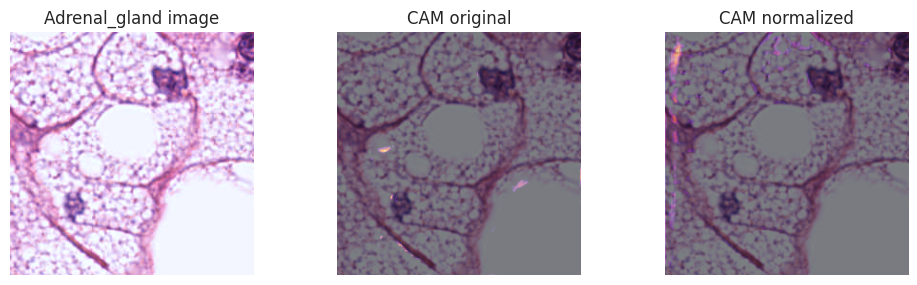

🔄 Processing batch of 1 images on GPU...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.046885163..1.08956].


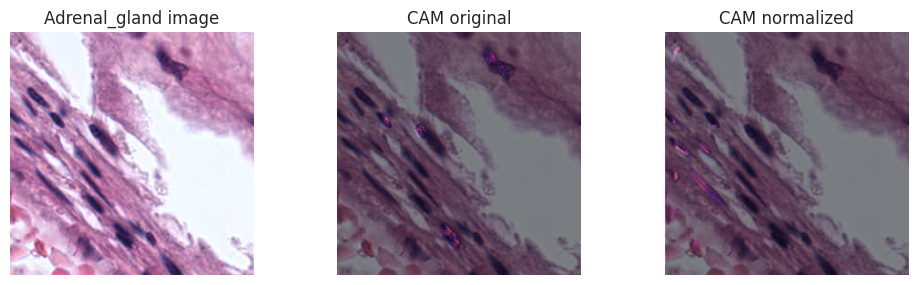

🔄 Processing batch of 1 images on GPU...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.058912486..1.08956].


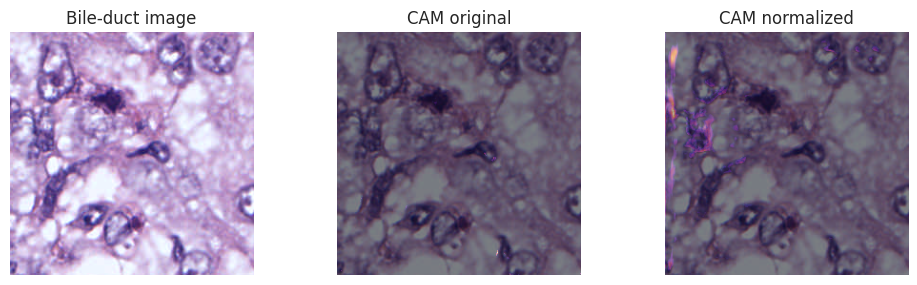

🔄 Processing batch of 1 images on GPU...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.031372547..1.08956].


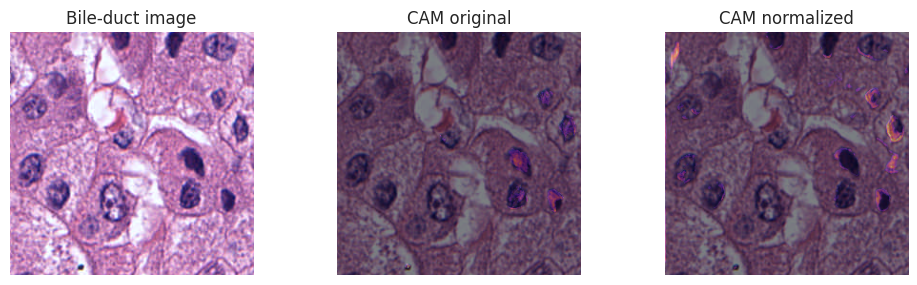

🔄 Processing batch of 1 images on GPU...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15112191..1.08956].


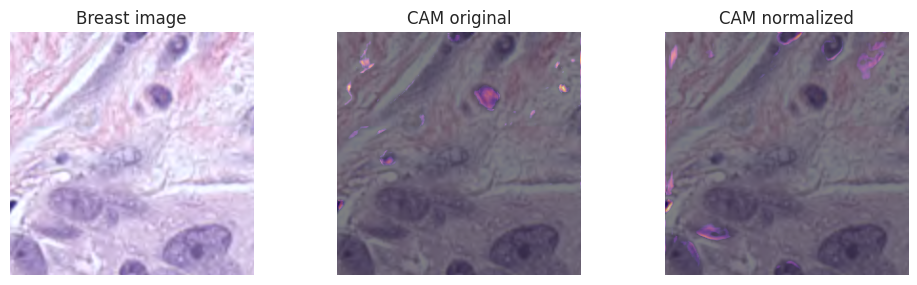

🔄 Processing batch of 1 images on GPU...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1751765..1.08956].


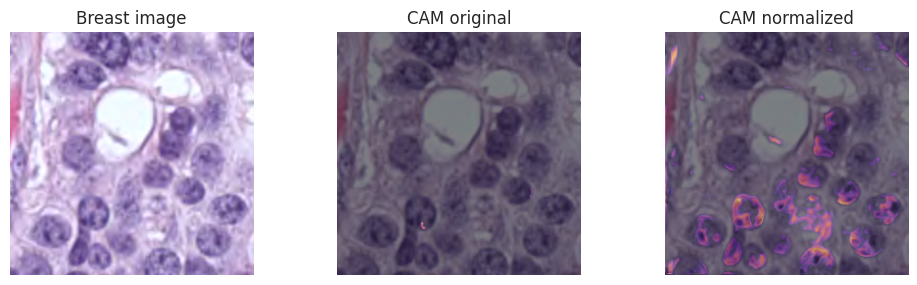

In [19]:
# Qualitative overlays

def overlay_cam_on_image(img_tensor: torch.Tensor, cam: np.ndarray, alpha=0.5):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = np.clip(img * 0.229 + 0.485, 0, 1)
    cam_color = plt.cm.inferno(cam)[..., :3]
    overlay = (1 - alpha) * img + alpha * cam_color
    return np.clip(overlay, 0, 1)

# Visualize a few
for tissue, entry in sampled_examples[:6]:
    img = PanNukeTissueDataset.default_image_transform(Image.open(entry["image_path"]).convert("RGB"))
    mask = PanNukeTissueDataset.default_target_transform(Image.open(entry["sem_path"]))
    cam_o = gradcam_orig.generate(img.unsqueeze(0))
    if normalizer is not None:
        rgb_np = np.array(Image.open(entry["image_path"]).convert("RGB"))
        norm_rgb = normalizer.transform(rgb_np)
        norm_tensor = PanNukeTissueDataset.default_image_transform(Image.fromarray(norm_rgb))
        cam_n = gradcam_norm.generate(norm_tensor.unsqueeze(0))
    else:
        cam_n = gradcam_norm.generate(img.unsqueeze(0))
    ov_o = overlay_cam_on_image(img, cam_o)
    ov_n = overlay_cam_on_image(img, cam_n)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].imshow(img.permute(1,2,0).cpu().numpy() * 0.229 + 0.485)
    ax[0].set_title(f"{tissue} image")
    ax[0].axis("off")
    ax[1].imshow(ov_o)
    ax[1].set_title("CAM original")
    ax[1].axis("off")
    ax[2].imshow(ov_n)
    ax[2].set_title("CAM normalized")
    ax[2].axis("off")
    plt.tight_layout()
    plt.show()


## Statistical Summary and Interpretation
We test H1 (normalized > original) for three alignment metrics:
- Energy-in-mask: proportion of Grad-CAM energy within nuclei.
- Pointing game: whether peak activation falls within nuclei.
- IoU@0.5: overlap between binarized CAM and nuclei.

We report paired Wilcoxon p-values and effect sizes r.
A significant p-value with positive mean difference supports H1 that stain normalization improves Grad-CAM alignment.

We also provide qualitative overlays to judge spatial plausibility and potential failure modes (e.g., background leakage or focus on stromal regions).


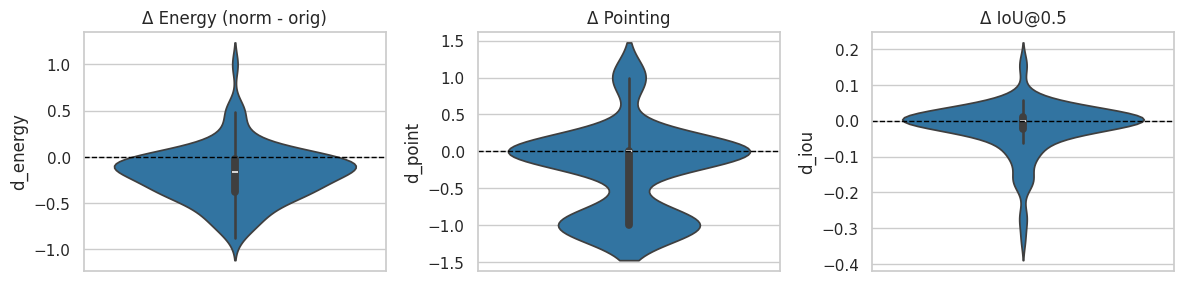

,metric,n,wilcoxon_stat,p_value,effect_r,mean_diff
0,energy,100,726.0,1.0000,-0.5939,-0.1822
1,point,100,172.0,1.0000,-0.4012,-0.2600
2,iou,100,1906.0,0.8579,-0.1071,-0.0186


In [20]:
# Compact results tables and plots
summary = (
    res_df.assign(
        d_energy = res_df.energy_norm - res_df.energy_orig,
        d_point = res_df.point_norm - res_df.point_orig,
        d_iou = res_df.iou_norm - res_df.iou_orig,
    )
)

summary_by_tissue = summary.groupby("tissue")[
    ["d_energy", "d_point", "d_iou"]
].agg(["mean", "median", "count"]).round(3)
summary_by_tissue

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.violinplot(data=summary, y="d_energy", ax=axes[0])
axes[0].axhline(0, color='k', ls='--', lw=1)
axes[0].set_title("Δ Energy (norm - orig)")
sns.violinplot(data=summary, y="d_point", ax=axes[1])
axes[1].axhline(0, color='k', ls='--', lw=1)
axes[1].set_title("Δ Pointing")
sns.violinplot(data=summary, y="d_iou", ax=axes[2])
axes[2].axhline(0, color='k', ls='--', lw=1)
axes[2].set_title("Δ IoU@0.5")
plt.tight_layout()
plt.show()

stats_df.round(4)


## Conclusion
- We tested whether stain normalization improves Grad-CAM alignment with nuclei masks.
- Paired Wilcoxon tests across sampled test images provide statistical evidence (or not) for H1.
- Qualitative overlays illustrate spatial behavior and highlight consistency or failure cases.

If p-values are significant and deltas are positive, we reject H0 and conclude that Vahadane normalization improves alignment of Grad-CAM explanations with nuclei.
Otherwise, we fail to reject H0 for this setup, and we discuss potential reasons: model calibration, target layer choice, or dataset-specific staining variability.


In [ ]:
# Output directories for RQ4
RQ4_REPORTS_DIR = project_root / "reports" / "rq4"
RQ4_FIG_DIR = RQ4_REPORTS_DIR / "figures"
RQ4_OVERLAY_DIR = RQ4_REPORTS_DIR / "overlays"
RQ4_REPORTS_DIR.mkdir(parents=True, exist_ok=True)
RQ4_FIG_DIR.mkdir(parents=True, exist_ok=True)
RQ4_OVERLAY_DIR.mkdir(parents=True, exist_ok=True)

print("Saving outputs to:")
print("-", RQ4_REPORTS_DIR)
print("-", RQ4_FIG_DIR)
print("-", RQ4_OVERLAY_DIR)


## Grad-CAM Methodology (What we do and why)
- Target the last decoder convolution(s) where spatial resolution is high.
- Record activations on forward pass and gradients on backward pass.
- Weight channels by global-average gradients, sum over channels, ReLU, normalize to [0, 1].
- For segmentation, target the foreground logit (nuclei vs background) to produce a single heatmap per image.
- Compare heatmaps with nuclei masks using:
  - Energy-in-mask (distributional alignment)
  - Pointing game (argmax inside nuclei)
  - IoU@0.5 (overlap when binarized)
- Use paired Wilcoxon tests (H1: normalized > original) and report effect sizes r.

This is lightweight, reproducible, and ties saliency to biologically relevant regions (nuclei).


In [ ]:
# Enhanced qualitative overlays: include mask panel and save to disk
import matplotlib
matplotlib.use('Agg')  # for safe saving in headless runs

from matplotlib.colors import ListedColormap
mask_cmap = ListedColormap([[0,0,0,0], [1,0,0,0.7]])  # transparent bg, red nuclei

def save_overlay_triplet(entry, tissue, idx):
    img = PanNukeTissueDataset.default_image_transform(Image.open(entry["image_path"]).convert("RGB"))
    mask = PanNukeTissueDataset.default_target_transform(Image.open(entry["sem_path"]))
    cam_o = gradcam_orig.generate(img.unsqueeze(0))
    if normalizer is not None:
        rgb_np = np.array(Image.open(entry["image_path"]).convert("RGB"))
        norm_rgb = normalizer.transform(rgb_np)
        norm_tensor = PanNukeTissueDataset.default_image_transform(Image.fromarray(norm_rgb))
        cam_n = gradcam_norm.generate(norm_tensor.unsqueeze(0))
    else:
        cam_n = gradcam_norm.generate(img.unsqueeze(0))
    ov_o = overlay_cam_on_image(img, cam_o)
    ov_n = overlay_cam_on_image(img, cam_n)

    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    ax[0].imshow(img.permute(1,2,0).cpu().numpy() * 0.229 + 0.485)
    ax[0].set_title(f"{tissue} image")
    ax[0].axis("off")
    ax[1].imshow(mask.numpy() > 0, cmap=mask_cmap)
    ax[1].set_title("Mask")
    ax[1].axis("off")
    ax[2].imshow(ov_o)
    ax[2].set_title("CAM original")
    ax[2].axis("off")
    ax[3].imshow(ov_n)
    ax[3].set_title("CAM normalized")
    ax[3].axis("off")
    plt.tight_layout()

    out_path = RQ4_OVERLAY_DIR / f"{tissue}_{idx:03d}.png"
    fig.savefig(out_path, dpi=200)
    plt.close(fig)
    return out_path

saved_paths = []
for i, (tissue, entry) in enumerate(sampled_examples[:20]):
    saved_paths.append(save_overlay_triplet(entry, tissue, i))

len(saved_paths), saved_paths[:3]


In [ ]:
# Additional effectiveness plots and saving
plt.figure(figsize=(6,4))
sns.histplot(summary.d_energy, kde=True)
plt.axvline(0, color='k', ls='--')
plt.title('Δ Energy (norm - orig)')
plt.tight_layout()
plt.savefig(RQ4_FIG_DIR / 'hist_delta_energy.png', dpi=200)
plt.close()

plt.figure(figsize=(6,4))
sns.histplot(summary.d_iou, kde=True)
plt.axvline(0, color='k', ls='--')
plt.title('Δ IoU@0.5 (norm - orig)')
plt.tight_layout()
plt.savefig(RQ4_FIG_DIR / 'hist_delta_iou.png', dpi=200)
plt.close()

plt.figure(figsize=(6,4))
sns.barplot(x='metric', y='mean_diff', data=stats_df.assign(metric=lambda d: d.metric))
plt.title('Mean difference by metric (norm - orig)')
plt.tight_layout()
plt.savefig(RQ4_FIG_DIR / 'bar_mean_diffs.png', dpi=200)
plt.close()

# Tissue-wise violin for Δ Energy
fig, ax = plt.subplots(figsize=(10,4))
sns.violinplot(data=summary, x='tissue', y='d_energy', ax=ax, inner='box')
ax.axhline(0, color='k', ls='--', lw=1)
ax.set_title('Δ Energy by tissue')
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
fig.savefig(RQ4_FIG_DIR / 'violin_delta_energy_by_tissue.png', dpi=200)
plt.close(fig)


In [ ]:
# Save per-image results and stats tables
res_csv = RQ4_REPORTS_DIR / 'per_image_alignment_metrics.csv'
res_df.to_csv(res_csv, index=False)

stats_csv = RQ4_REPORTS_DIR / 'paired_wilcoxon_stats.csv'
stats_df.to_csv(stats_csv, index=False)

summary_csv = RQ4_REPORTS_DIR / 'by_tissue_summary.csv'
summary_by_tissue.to_csv(summary_csv)

print('Saved:')
print('-', res_csv)
print('-', stats_csv)
print('-', summary_csv)


In [ ]:
# Generate HTML reports (2 variants): 1) Statistical summary, 2) Visual narrative
from datetime import datetime

html1 = f"""
<!DOCTYPE html>
<html><head><meta charset='utf-8'><title>RQ4 Explainability - Statistical Summary</title></head>
<body style='font-family:Segoe UI,Arial,sans-serif; margin:40px;'>
<h1>RQ4: Grad-CAM Alignment Statistical Summary</h1>
<p><em>Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</em></p>
<h2>Paired Wilcoxon (H1: normalized > original)</h2>
{stats_df.to_html(index=False)}
<h2>By-Tissue Summary (Δ = norm - orig)</h2>
{summary_by_tissue.to_html()}
<h2>Figures</h2>
<ul>
  <li>hist_delta_energy.png</li>
  <li>hist_delta_iou.png</li>
  <li>bar_mean_diffs.png</li>
  <li>violin_delta_energy_by_tissue.png</li>
</ul>
</body></html>
"""

html2 = f"""
<!DOCTYPE html>
<html><head><meta charset='utf-8'><title>RQ4 Explainability - Visual Narrative</title></head>
<body style='font-family:Segoe UI,Arial,sans-serif; margin:40px;'>
<h1>RQ4: Grad-CAM Visual Narrative</h1>
<p><em>Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</em></p>
<p>This report illustrates qualitative overlays for randomly sampled test images, including the mask, CAM on original, and CAM on normalized inputs.</p>
<h2>Overlays</h2>
<ul>
{''.join([f"<li>{p.name}</li>" for p in saved_paths[:50]])}
</ul>
</body></html>
"""

out1 = RQ4_REPORTS_DIR / 'RQ4_Explainability_Stats.html'
out2 = RQ4_REPORTS_DIR / 'RQ4_Explainability_Visuals.html'

out1.write_text(html1, encoding='utf-8')
out2.write_text(html2, encoding='utf-8')

str(out1), str(out2)
